# Classifying CIFAR10 images using ResNets, Regularization and Data Augmentation in PyTorch

_A.K.A. Training an image classifier from scratch to over 90% accuracy in less than 5 minutes on a single GPU_

### Part 6 of "Deep Learning with Pytorch: Zero to GANs"

This tutorial series is a hands-on beginner-friendly introduction to deep learning using [PyTorch](https://pytorch.org), an open-source neural networks library. These tutorials take a practical and coding-focused approach. The best way to learn the material is to execute the code and experiment with it yourself. Check out the full series here:

1. [PyTorch Basics: Tensors & Gradients](https://jovian.ai/aakashns/01-pytorch-basics)
2. [Gradient Descent & Linear Regression](https://jovian.ai/aakashns/02-linear-regression)
3. [Working with Images & Logistic Regression](https://jovian.ai/aakashns/03-logistic-regression) 
4. [Training Deep Neural Networks on a GPU](https://jovian.ai/aakashns/04-feedforward-nn)
5. [Image Classification using Convolutional Neural Networks](https://jovian.ai/aakashns/05-cifar10-cnn)
6. [Data Augmentation, Regularization and ResNets](https://jovian.ai/aakashns/05b-cifar10-resnet)
7. [Generating Images using Generative Adversarial Networks](https://jovian.ai/aakashns/06b-anime-dcgan/)



In this tutorial, we'll use the following techniques to train a state-of-the-art model in less than 5 minutes to achieve over 90% accuracy in  classifying images from the CIFAR10 dataset:

- Data normalization
- Data augmentation
- Residual connections
- Batch normalization
- Learning rate scheduling
- Weight Decay
- Gradient clipping
- Adam optimizer

### How to run the code

This tutorial is an executable [Jupyter notebook](https://jupyter.org) hosted on [Jovian](https://www.jovian.ai). You can _run_ this tutorial and experiment with the code examples in a couple of ways: *using free online resources* (recommended) or *on your computer*.

#### Option 1: Running using free online resources (1-click, recommended)

The easiest way to start executing the code is to click the **Run** button at the top of this page and select **Run on Colab**. [Google Colab](https://colab.research.google.com) is a free online platform for running Jupyter notebooks using Google's cloud infrastructure. You can also select "Run on Binder" or "Run on Kaggle" if you face issues running the notebook on Google Colab. 


#### Option 2: Running on your computer locally

To run the code on your computer locally, you'll need to set up [Python](https://www.python.org), download the notebook and install the required libraries. We recommend using the [Conda](https://docs.conda.io/projects/conda/en/latest/user-guide/install/) distribution of Python. Click the **Run** button at the top of this page, select the **Run Locally** option, and follow the instructions.

### Using a GPU for faster training

You can use a [Graphics Processing Unit](https://en.wikipedia.org/wiki/Graphics_processing_unit) (GPU) to train your models faster if your execution platform is connected to a GPU manufactured by NVIDIA. Follow these instructions to use a GPU on the platform of your choice:

* _Google Colab_: Use the menu option "Runtime > Change Runtime Type" and select "GPU" from the "Hardware Accelerator" dropdown.
* _Kaggle_: In the "Settings" section of the sidebar, select "GPU" from the "Accelerator" dropdown. Use the button on the top-right to open the sidebar.
* _Binder_: Notebooks running on Binder cannot use a GPU, as the machines powering Binder aren't connected to any GPUs.
* _Linux_: If your laptop/desktop has an NVIDIA GPU (graphics card), make sure you have installed the [NVIDIA CUDA drivers](https://docs.nvidia.com/cuda/cuda-installation-guide-linux/index.html).
* _Windows_: If your laptop/desktop has an NVIDIA GPU (graphics card), make sure you have installed the [NVIDIA CUDA drivers](https://docs.nvidia.com/cuda/cuda-installation-guide-microsoft-windows/index.html).
* _macOS_: macOS is not compatible with NVIDIA GPUs


If you do not have access to a GPU or aren't sure what it is, don't worry, you can execute all the code in this tutorial just fine without a GPU.<br>
**Mert:** Convert markdown cell below to install the packages if needed.

```python
# Uncomment and run the appropriate command for your operating system, if required
# No installation is reqiured on Google Colab / Kaggle notebooks

# Linux / Binder / Windows (No GPU)
# !pip install numpy matplotlib torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# Linux / Windows (GPU)
# pip install torch==1.7.1+cu110 torchvision==0.8.2+cu110 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html
 
# MacOS (NO GPU)
# !pip install numpy matplotlib torch torchvision torchaudio
```

In [2]:
import os
import torch
import tarfile
import numpy as np
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [3]:
project_name='05b-cifar10-resnet'

## Preparing the CIFAR10 Dataset

This notebook is an extension to the tutorial [Image Classification using CNNs in PyTorch](https://jovian.ai/aakashns/05-cifar10-cnn), where we trained a deep convolutional neural network to classify images from the CIFAR10 dataset with around 75% accuracy. Here are some images from the dataset:

![cifar10](https://miro.medium.com/max/709/1*LyV7_xga4jUHdx4_jHk1PQ.png)


Let's begin by downloading the dataset and creating PyTorch datasets to load the data, just as we did in the previous tutorial.

In [4]:
from torchvision.datasets.utils import download_url
# Dowload the dataset
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, '.')

# Extract from archive
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')
    
# Look into the data directory
data_dir = './data/cifar10'
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

Using downloaded and verified file: ./cifar10.tgz
['test', 'train']
['dog', 'frog', 'horse', 'deer', 'airplane', 'ship', 'truck', 'bird', 'automobile', 'cat']


We can create training and validation datasets using the `ImageFolder` class from `torchvision`. In addition to the `ToTensor` transform, we'll also apply some other transforms to the images. There are a few important changes we'll make while creating PyTorch datasets for training and validation:

1. **Use test set for validation**: Instead of setting aside a fraction (e.g. 10%) of the data from the training set for validation, we'll simply use the test set as our validation set. This just gives a little more data to train with. In general, once you have picked the best model architecture & hypeparameters using a fixed validation set, it is a good idea to retrain the same model on the entire dataset just to give it a small final boost in performance.
2. **Channel-wise data normalization**: We will normalize the image tensors by subtracting the mean and dividing by the standard deviation across each channel. As a result, the mean of the data across each channel is 0, and standard deviation is 1. Normalizing the data prevents the values from any one channel from disproportionately affecting the losses and gradients while training, simply by having a higher or wider range of values that others.

<img src="https://i.imgur.com/LYxXBVg.png" width="360">


3. **Randomized data augmentations**: We will apply randomly chosen transformations while loading images from the training dataset. Specifically, we will pad each image by 4 pixels, and then take a random crop of size 32 x 32 pixels, and then flip the image horizontally with a 50% probability. Since the transformation will be applied randomly and dynamically each time a particular image is loaded, the model sees slightly different images in each epoch of training, which allows it generalize better.

![data-augmentation](https://imgaug.readthedocs.io/en/latest/_images/cropandpad_percent.jpg)

**Mert:** They didn't explain how the `standart deviation` and `mean value` of the CIFAR10 dataset was calculated below. I wrote the code and set the `batch_size` to 1 not to take the `mean` & `std` of the batches. We calculated them over EACH image not to calculate approximate values. As you can see, the calculated and predefined (by Jovian) values are almost the same.<br>The code below takes about a minute. Thus, I paste it under a `markdown` cell. You can copy/paste it to a cell and get the exact results. 

```python
%%time
temp_set = DataLoader(
    ImageFolder(
        data_dir+"/train",
        tt.ToTensor()),
    batch_size=1)
channel_mean = [[], [], []]  # Channels 0, 1 & 2, respectively.
channel_std = [[], [], []]
for channel in range(3):
    for img, _ in temp_set:
        # torch.Size([1, 3, 32, 32])  # (Batch_Size, C, H, W)
        channel_mean[channel].append(img[:, channel, :, :].mean())
        channel_std[channel].append(img[:, channel, :, :].std())
    channel_mean[channel] = np.mean(channel_mean[channel])
    channel_std[channel] = np.mean(channel_std[channel])
print("Mean value of 50k CIFAR10 image channels:", channel_mean)
print("Std value of 50k CIFAR10 image channels :", channel_std)
del temp_set
# Output:
```
```
Mean value of 50k CIFAR10 image channels: [0.49139968, 0.4821584, 0.44653094]
Std value of 50k CIFAR10 image channels : [0.20230094, 0.19941281, 0.2009616]
CPU times: user 1min 13s, sys: 3.64 s, total: 1min 17s
Wall time: 1min 18s
```

In [5]:
# Data transforms (normalization & data augmentation)
channel_mean = [0.49139968, 0.4821584, 0.44653094]
channel_std = [0.20230094, 0.19941281, 0.2009616]
# stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))  # Mert: Jovian default.
stats = (channel_mean, channel_std)
train_tfms = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'), 
                         tt.RandomHorizontalFlip(), 
                         # tt.RandomRotate
                         # tt.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)), 
                         # tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                         tt.ToTensor(), 
                         tt.Normalize(*stats, inplace=True)])
valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

**Mert:** Also, [this post](https://discuss.pytorch.org/t/discussion-why-normalise-according-to-imagenet-mean-and-std-dev-for-transfer-learning/115670/6) explains why you should take the `mean` and `std` of ***your own dataset*** to normalize the channels.

In [6]:
# PyTorch datasets
train_ds = ImageFolder(data_dir+'/train', train_tfms)
valid_ds = ImageFolder(data_dir+'/test', valid_tfms)

Class: 0


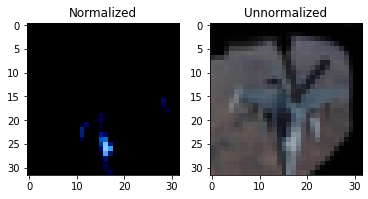

In [7]:
# Mert: Normalized vs Unnormalized Image
def normalizationCompare(IMG=10):
    print(f"Class: {train_ds[IMG][1]}")
    plt.subplot(1,2,1)
    plt.title("Normalized")
    normalized_img = train_ds[IMG][0].permute((1,2,0)).clamp(0, 1)
    plt.imshow(normalized_img);
    plt.subplot(1,2,2)
    plt.title("Unnormalized")
    unnormalized_img = ImageFolder(
        data_dir+"/train",
        tt.ToTensor()
        )[IMG][0].permute((1,2,0)).clamp(0, 1)
    plt.imshow(unnormalized_img);

normalizationCompare(10)

**Mert:** So, you are asking yourself how the f\*ck will the model learn ***better*** from the image at LEFT. Note that it is clamped to `[0, 1]` for `matplotlib` to process it (it clamps the img whether you do it manually or not anyway). Also remember that the model _sees_ a different data.<br>
<details>
  <summary><i>Spoiler warning!</i></summary>
When under <b>the same model architecture</b>, the accuracy drops to half where the loss increases by a similar rate when the normalization is <b>REMOVED</b>. Thus, the model obviously can see what you can't by naked eye.
</details>

Next, we can create data loaders for retrieving images in batches. We'll use a relatively large batch size of 500 to utlize a larger portion of the GPU RAM. You can try reducing the batch size & restarting the kernel if you face an "out of memory" error.

In [8]:
batch_size = 512

In [9]:
# PyTorch data loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=2, pin_memory=True)

Let's take a look at some sample images from the training dataloader. To display the images, we'll need to _denormalize_ the pixels values to bring them back into the range `(0,1)`.

In [10]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl, wanna_denormalize=True, fix_seed=None):  # Mert: Modified.
    if fix_seed: torch.manual_seed(fix_seed)
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        if wanna_denormalize:
            denorm_images = denormalize(images, *stats)
        else:
            denorm_images = images
        ax.imshow(
            make_grid(
                denorm_images[:64],
                nrow=8
                ).permute(1, 2, 0).clamp(0, 1)
                )
        break

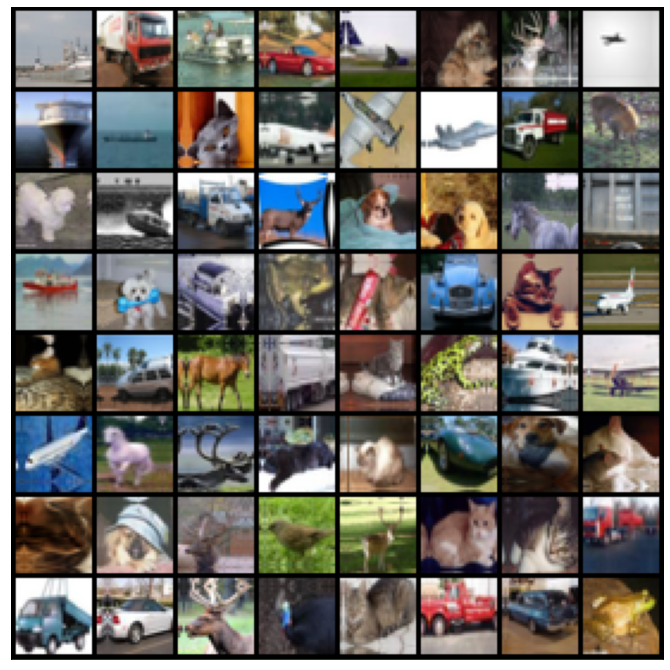

In [11]:
show_batch(train_dl, fix_seed=42)

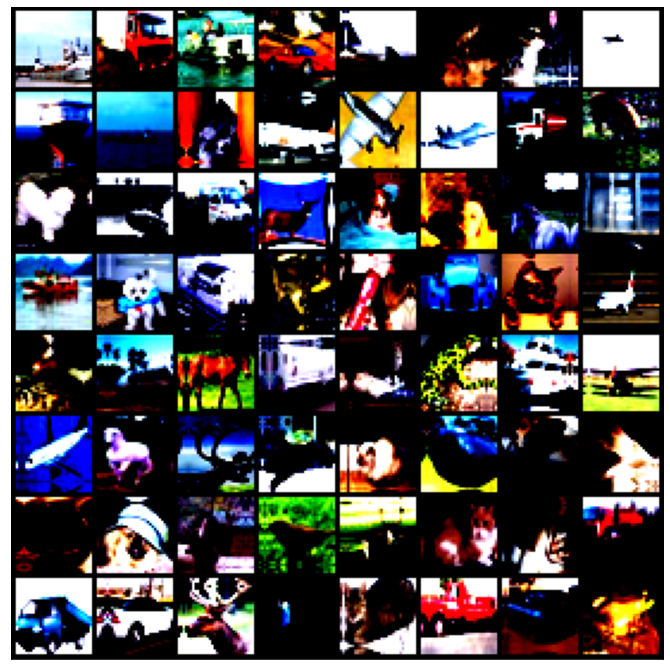

In [12]:
show_batch(train_dl, False, 42)

The colors seem out of place because of the normalization. Note that normalization is also applied during inference. If you look closely, you can see the cropping and reflection padding in some of the images. Horizontal flip is a bit difficult to detect from visual inspection.

## Using a GPU

To seamlessly use a GPU, if one is available, we define a couple of helper functions (`get_default_device` & `to_device`) and a helper class `DeviceDataLoader` to move our model & data to the GPU as required. These are described in more detail in a [previous tutorial](https://jovian.ml/aakashns/04-feedforward-nn#C21).

In [13]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

Based on where you're running this notebook, your default device could be a CPU (`torch.device('cpu')`) or a GPU (`torch.device('cuda')`)

In [14]:
device = get_default_device()
device

device(type='cuda')

We can now wrap our training and validation data loaders using `DeviceDataLoader` for automatically transferring batches of data to the GPU (if available).

In [15]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

## Model with Residual Blocks and Batch Normalization

One of the key changes to our CNN model this time is the addition of the resudial block, which adds the original input back to the output feature map obtained by passing the input through one or more convolutional layers.

![](https://miro.medium.com/max/1140/1*D0F3UitQ2l5Q0Ak-tjEdJg.png)

Here is a very simple Residual block:

In [16]:
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out) + x # ReLU can be applied before or after adding the input

In [17]:
simple_resnet = to_device(SimpleResidualBlock(), device)

for images, labels in train_dl:
    out = simple_resnet(images)
    print(out.shape)
    break
    
del simple_resnet, images, labels
torch.cuda.empty_cache()

torch.Size([512, 3, 32, 32])


This seeming small change produces a drastic improvement in the performance of the model. Also, after each convolutional layer, we'll add a batch normalization layer, which normalizes the outputs of the previous layer. 

Go through the following blog posts to learn more:

* Why and how residual blocks work: https://towardsdatascience.com/residual-blocks-building-blocks-of-resnet-fd90ca15d6ec
* Batch normalization and dropout explained: https://towardsdatascience.com/batch-normalization-and-dropout-in-neural-networks-explained-with-pytorch-47d7a8459bcd

We will use the ResNet9 architecture, as described in [this blog series](https://www.myrtle.ai/2018/09/24/how_to_train_your_resnet/) :

![resnet-9](https://github.com/lambdal/cifar10-fast/raw/master/net.svg?sanitize=true)

In [18]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}]: last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [24]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        # Input (image) size: 3x32x32
        self.conv1 = conv_block(in_channels, 64)  # ((32-3+2*1)/1)+1 = 32 (So, 64x32x32)
        self.conv2 = conv_block(64, 128, pool=True)  # 128x16x16
        self.res1 = nn.Sequential(
            conv_block(128, 128),
            conv_block(128, 128))  # Same
        self.conv3 = conv_block(128, 256, pool=True)  # 256x8x8
        self.conv4 = conv_block(256, 512, pool=True)  # 512x4x4
        self.res2 = nn.Sequential(
            conv_block(512, 512),
            conv_block(512, 512))  # Same
        self.classifier = nn.Sequential(nn.MaxPool2d(2),  # 512x2x2
                                        nn.Flatten(),  # 512*2*2 = 2048
                                        nn.Dropout(0.2),
                                        nn.Linear(512*2*2, 1024),
                                        nn.BatchNorm1d(1024),
                                        nn.Linear(1024, 512),
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
    def forward(self, xb):
        out1 = self.conv1(xb)
        out2 = self.conv2(out1)
        out3 = self.res1(out2) + out2
        out4 = self.conv3(out3)
        out5 = self.conv4(out4)
        out6 = self.res2(out5) + out5
        out7 = self.classifier(out6)
        return out7

In [25]:
model = to_device(ResNet9(3, 10), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

## Training the model

Before we train the model, we're going to make a bunch of small but important improvements to our `fit` function:

* **Learning rate scheduling**: Instead of using a fixed learning rate, we will use a learning rate scheduler, which will change the learning rate after every batch of training. There are many strategies for varying the learning rate during training, and the one we'll use is called the **"One Cycle Learning Rate Policy"**, which involves starting with a low learning rate, gradually increasing it batch-by-batch to a high learning rate for about 30% of epochs, then gradually decreasing it to a very low value for the remaining epochs. Learn more: https://sgugger.github.io/the-1cycle-policy.html

* **Weight decay (L2 regularization)**: We also use weight decay, which is yet another regularization technique which prevents the weights from becoming too large by adding an additional term to the loss function.Learn more: https://towardsdatascience.com/this-thing-called-weight-decay-a7cd4bcfccab

* **Gradient clipping**: Apart from the layer weights and outputs, it also helpful to limit the values of gradients to a small range to prevent undesirable changes in parameters due to large gradient values. This simple yet effective technique is called gradient clipping. Learn more: https://towardsdatascience.com/what-is-gradient-clipping-b8e815cdfb48


Let's define a `fit_one_cycle` function to incorporate these changes. We'll also record the learning rate used for each batch.

**Mert:** Why `model.eval()` below? The passage below taken from [here](https://stackoverflow.com/questions/60018578/what-does-model-eval-do-in-pytorch):<br>
_`model.eval()` is a kind of switch for some specific layers/parts of the model that behave differently during training and inference (evaluating) time. For example, Dropouts Layers, BatchNorm Layers etc. You need to turn off them during model evaluation, and `.eval()` will do it for you. In addition, the common practice for evaluating/validation is using `torch.no_grad()` in pair with `model.eval()` to turn off gradients computation._<br>
Mert: We want to keep things as less random as possible while evaluating.

In [26]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(
        model.parameters(),
        max_lr,
        weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr,
        epochs=epochs,
        steps_per_epoch=len(train_loader))    
    for epoch in range(1, epochs+1):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            optimizer.step()
            optimizer.zero_grad()
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

**Mert:** Please take a look at the [OneCycleLR doc](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.OneCycleLR.html#torch.optim.lr_scheduler.OneCycleLR). This is different from [StepLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.StepLR.html) (see: my Assignment 3 notebook) which adjusts the `lr` after each epoch. Thus it should be called under the epoch `for` loop. However, `OneCycleLR` is different: _"The 1cycle learning rate policy changes the learning rate after every batch. `step` should be called after a batch has been used for training."_

In [27]:
history = [evaluate(model, valid_dl)]
history

[{'val_acc': 0.09931640326976776, 'val_loss': 2.303717613220215}]

We're now ready to train our model. Instead of SGD (stochastic gradient descent), we'll use the Adam optimizer which uses techniques like momentum and adaptive learning rates for faster training. You can learn more about optimizers here: https://ruder.io/optimizing-gradient-descent/index.html

In [28]:
epochs = 10
max_lr = 0.008
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [29]:
import time
start = time.time()
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl,
                         grad_clip=grad_clip,
                         weight_decay=weight_decay,
                         opt_func=opt_func)

elapsed = time.gmtime(time.time() - start)
train_time = time.strftime("%M:%S",(elapsed))
print("The model finished in:", train_time, "minutes.")

Epoch [1]: last_lr: 0.00222, train_loss: 1.3555, val_loss: 1.7366, val_acc: 0.5138
Epoch [2]: last_lr: 0.00607, train_loss: 0.9807, val_loss: 1.4263, val_acc: 0.5730
Epoch [3]: last_lr: 0.00800, train_loss: 0.8378, val_loss: 0.8213, val_acc: 0.7218
Epoch [4]: last_lr: 0.00760, train_loss: 0.6501, val_loss: 0.7680, val_acc: 0.7475
Epoch [5]: last_lr: 0.00649, train_loss: 0.5523, val_loss: 0.8478, val_acc: 0.7188
Epoch [6]: last_lr: 0.00489, train_loss: 0.4682, val_loss: 0.5454, val_acc: 0.8190
Epoch [7]: last_lr: 0.00311, train_loss: 0.3875, val_loss: 0.5560, val_acc: 0.8165
Epoch [8]: last_lr: 0.00151, train_loss: 0.3030, val_loss: 0.3569, val_acc: 0.8775
Epoch [9]: last_lr: 0.00040, train_loss: 0.2206, val_loss: 0.2746, val_acc: 0.9064
Epoch [10]: last_lr: 0.00000, train_loss: 0.1698, val_loss: 0.2604, val_acc: 0.9127
The model finished in: 11:16 seconds.


Our model trained to over **90% accuracy in under 5 minutes**! Try playing around with the data augmentations, network architecture & hyperparameters to achive the following results:

1. 94% accuracy in under 10 minutes (easy)
2. 90% accuracy in under 2.5 minutes (intermediate)
3. 94% accuracy in under 5 minutes (hard)


Let's plot the valdation set accuracies to study how the model improves over time.

In [30]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-o', color="crimson")
    plt.grid(b=True, color="gray", linestyle=(0, (5, 10)))
    plt.xlabel('epoch', size=14)
    plt.ylabel('accuracy', size=14)
    plt.title('Accuracy vs. No. of epochs', size=16)
    plt.show()

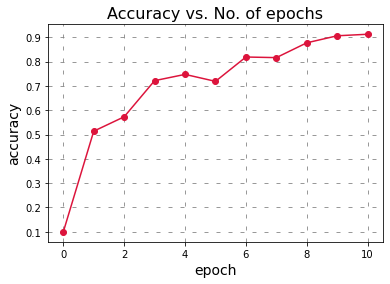

In [31]:
plot_accuracies(history)

We can also plot the training and validation losses to study the trend.

In [32]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.grid(b=True, color="gray", linestyle=(0, (5, 10)))
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

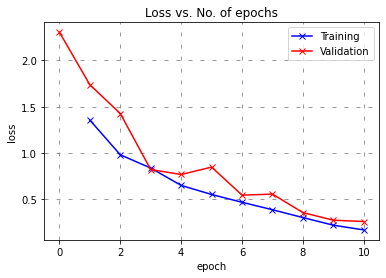

In [33]:
plot_losses(history)

It's clear from the trend that our model isn't overfitting to the training data just yet. Try removing batch normalization, data augmentation and residual layers one by one to study their effect on overfitting.

Finally, let's visualize how the learning rate changed over time, batch-by-batch over all the epochs.

In [34]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.grid(b=True, color="gray", linestyle=(0, (5, 10)))
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

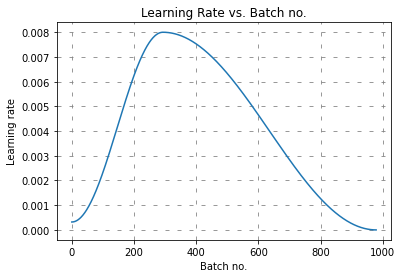

In [35]:
plot_lrs(history)

As expected, the learning rate starts at a low value, and gradually increases for 30% of the iterations to a maximum value of `0.01`, and then gradually decreases to a very small value.

## Testing with individual images

While we have been tracking the overall accuracy of a model so far, it's also a good idea to look at model's results on some sample images. Let's test out our model with some images from the predefined test dataset of 10000 images.



In [36]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return train_ds.classes[preds[0].item()]

Label: airplane , Predicted: airplane


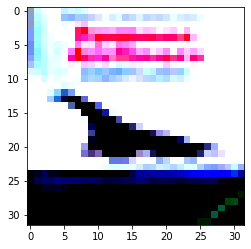

In [37]:
img, label = valid_ds[0]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: automobile , Predicted: truck


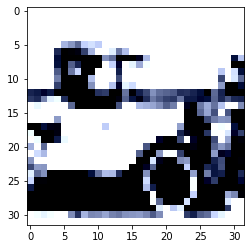

In [38]:
img, label = valid_ds[1002]
plt.imshow(img.permute(1, 2, 0))
print('Label:', valid_ds.classes[label], ', Predicted:', predict_image(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: frog , Predicted: frog


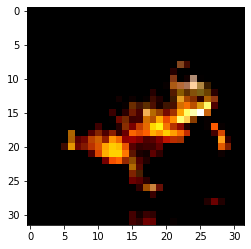

In [39]:
img, label = valid_ds[6153]
plt.imshow(img.permute(1, 2, 0))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Identifying where our model performs poorly can help us improve the model, by collecting more training data, increasing/decreasing the complexity of the model, and changing the hypeparameters.


## Save and Commit

Let's save the weights of the model, record the hyperparameters, and commit our experiment to Jovian. As you try different ideas, make sure to record every experiment so you can look back and analyze the results.

In [42]:
torch.save(model.state_dict(), 'cifar10-resnet9.pth')

In [43]:
!pip install jovian --upgrade --quiet

In [44]:
import jovian

In [ ]:
jovian.reset()
jovian.log_hyperparams(arch='resnet9', 
                       epochs=epochs, 
                       lr=max_lr, 
                       scheduler='one-cycle', 
                       weight_decay=weight_decay, 
                       grad_clip=grad_clip,
                       opt=opt_func.__name__)

In [ ]:
jovian.log_metrics(val_loss=history[-1]['val_loss'], 
                   val_acc=history[-1]['val_acc'],
                   train_loss=history[-1]['train_loss'],
                   time=train_time)

In [ ]:
jovian.commit(project=project_name, environment=None, outputs=['cifar10-resnet9.pth'])

## Summary and Further Reading

You are now ready to train state-of-the-art deep learning models from scratch. Try working on a project on your own by following these guidelines: https://jovian.ai/learn/deep-learning-with-pytorch-zero-to-gans/assignment/course-project

Here's a summary of the different techniques used in this tutorial to improve our model performance and reduce the training time:


* **Data normalization**: We normalized the image tensors by subtracting the mean and dividing by the standard deviation of pixels across each channel. Normalizing the data prevents the pixel values from any one channel from disproportionately affecting the losses and gradients. [Learn more](https://medium.com/@ml_kid/what-is-transform-and-transform-normalize-lesson-4-neural-networks-in-pytorch-ca97842336bd)

* **Data augmentation**: We applied random transformations while loading images from the training dataset. Specifically, we will pad each image by 4 pixels, and then take a random crop of size 32 x 32 pixels, and then flip the image horizontally with a 50% probability. [Learn more](https://www.analyticsvidhya.com/blog/2019/12/image-augmentation-deep-learning-pytorch/)

* **Residual connections**: One of the key changes to our CNN model was the addition of the resudial block, which adds the original input back to the output feature map obtained by passing the input through one or more convolutional layers. We used the ResNet9 architecture [Learn more](https://towardsdatascience.com/residual-blocks-building-blocks-of-resnet-fd90ca15d6ec).

* **Batch normalization**: After each convolutional layer, we added a batch normalization layer, which normalizes the outputs of the previous layer. This is somewhat similar to data normalization, except it's applied to the outputs of a layer, and the mean and standard deviation are learned parameters. [Learn more](https://towardsdatascience.com/batch-normalization-and-dropout-in-neural-networks-explained-with-pytorch-47d7a8459bcd)

* **Learning rate scheduling**: Instead of using a fixed learning rate, we will use a learning rate scheduler, which will change the learning rate after every batch of training. There are [many strategies](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate) for varying the learning rate during training, and we used the "One Cycle Learning Rate Policy". [Learn more](https://sgugger.github.io/the-1cycle-policy.html)

* **Weight Decay**: We added weight decay to the optimizer, yet another regularization technique which prevents the weights from becoming too large by adding an additional term to the loss function. [Learn more](https://towardsdatascience.com/this-thing-called-weight-decay-a7cd4bcfccab)

* **Gradient clipping**: We also added gradient clippint, which helps limit the values of gradients to a small range to prevent undesirable changes in model parameters due to large gradient values during training.  [Learn more.](https://towardsdatascience.com/what-is-gradient-clipping-b8e815cdfb48#63e0)

* **Adam optimizer**: Instead of SGD (stochastic gradient descent), we used the Adam optimizer which uses techniques like momentum and adaptive learning rates for faster training. There are many other optimizers to choose froma and experiment with. [Learn more.](https://ruder.io/optimizing-gradient-descent/index.html)


As an exercise, you should try applying each technique independently and see how much each one affects the performance and training time. As you try different experiments, you will start to cultivate the intuition for picking the right architectures, data augmentation & regularization techniques.

You are now ready to move on to the next tutorial in this series: [Generating Images using Generative Adversarial Networks](https://jovian.ai/aakashns/06b-anime-dcgan/)
